---

**An Analysis of Neural Network Architectures for Deep Quadratic Hedging**

---

**Ahmad Aghapour, Hamid Arian, Ali Fathi**

Abstract: This paper considers the deep stochastic optimal control methodology and examines the model uncertainty resulting from the choice of neural network architecture for quadratic hedging of a European Call option with transaction cost and under a discrete trading schedule. Researchers and quantitative finance practitioners have introduced various bespoke neural network architectures for the problem of deep hedging; however, we notice that methodology benchmarking in the literature has been limited to high-level performance analysis. Recognizing the intimate relationship between the deep stochastic optimal control and certain solution methods for trajectory optimization problems, we examine the interaction between model training and the choice of neural network architecture. We show that parameterizing the hedge ratio policies at each time step by an independent neural network is more consistent with the dynamics of the gradients in the ADAM optimization and result in better training and higher performance.

# Preliminaries

In [234]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats

import torch
import torch.nn.functional as F
from torch import nn, Tensor
import numpy as np
from torch.nn import Module, Linear, BatchNorm1d, Tanh
from numba import cuda
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import math
# import RiskLabAI
import pandas as pd
import matplotlib.pyplot as plt
import time
import psutil
import os

## Containers for Results

In [168]:
# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert bytes to MB

# Hyperparameters DataFrame
hyperparameters_data = {
    "Model Type": ["Feed-Forward", "DGM", "Deep BSDE"],
    "Learning Rate": [0.008, 0.008, 0.008],
    "Batch Size": [5000, 5000, 5000],
    "Optimizer": ["Adam", "Adam", "Adam"],
    "Epochs": [100, 100, 100],
    "Hidden Layer Sizes": ["[10, 20, 20, 20, 20, 10]", "30", "[10, 20, 20, 20, 20, 10]"]
}
hyperparameters_df = pd.DataFrame(hyperparameters_data)

# Computational Performance DataFrame with placeholder values
computational_performance_data = {
    "Model Type": ["Feed-Forward", "Feed-Forward", "DGM", "DGM", "Deep BSDE", "Deep BSDE"],
    "Time Horizon (T)": [30, 60, 30, 60, 30, 60],
    "Training Time (s)": [None, None, None, None, None, None],
    "Memory Usage (MB)": [None, None, None, None, None, None]
}
computational_performance_df = pd.DataFrame(computational_performance_data)

# Performance Metrics DataFrame
performance_metrics_data = {
    "Transaction Cost": [],
    "Feed-Forward Mean Log Loss": [],
    "DGM Mean Log Loss": [],
    "Deep BSDE Mean Log Loss": []
}
performance_metrics_df = pd.DataFrame(performance_metrics_data)

# Sensitivity Analysis DataFrame
sensitivity_data = {
    "Parameter": [],
    "Value": [],
    "Feed-Forward Sensitivity": [],
    "DGM Sensitivity": [],
    "Deep BSDE Sensitivity": []
}
sensitivity_df = pd.DataFrame(sensitivity_data)

In [169]:
"""
In this section we have used code available online in : https://github.com/frankhan91/DeepBSDE

"""

class StochasticProcess:
    """
    Base class for defining PDE related function.

    Args:
    eqn_config (dict): dictionary containing PDE configuration parameters

    Attributes:
    dim (int): dimensionality of the problem
    total_time (float): total time horizon
    num_time_interval (int): number of time steps
    delta_t (float): time step size
    sqrt_delta_t (float): square root of time step size
    y_init (None): initial value of the function
    """

    def __init__(self, eqn_config: dict):
        self.dim = eqn_config['dim']
        self.total_time = eqn_config['total_time']
        self.num_time_interval = eqn_config['num_time_interval']
        self.delta_t = self.total_time / self.num_time_interval
        self.sqrt_delta_t = np.sqrt(self.delta_t)
        self.y_init = None

    def sample(self, num_sample: int) -> Tensor:
        """
        Sample forward SDE.

        Args:
        num_sample (int): number of samples to generate

        Returns:
        Tensor: tensor of size [num_sample, dim+1] containing samples
        """
        raise NotImplementedError

    def r_u(self, t: float, x: Tensor, y: Tensor, z: Tensor) -> Tensor:
        """
        Interest rate in the PDE.

        Args:
        t (float): current time
        x (Tensor): tensor of size [batch_size, dim] containing space coordinates
        y (Tensor): tensor of size [batch_size, 1] containing function values
        z (Tensor): tensor of size [batch_size, dim] containing gradients

        Returns:
        Tensor: tensor of size [batch_size, 1] containing generator values
        """
        raise NotImplementedError

    def h_z(self, t,x,y,z: Tensor) -> Tensor:
        """
        Function to compute H(z) in the PDE.

        Args:
        h (float): value of H function
        z (Tensor): tensor of size [batch_size, dim] containing gradients

        Returns:
        Tensor: tensor of size [batch_size, dim] containing H(z)
        """
        raise NotImplementedError

    def terminal(self, x: Tensor) -> Tensor:
        """
        Terminal condition of the PDE.

        Args:
        t (float): current time
        x (Tensor): tensor of size [batch_size, dim] containing space coordinates

        Returns:
        Tensor: tensor of size [batch_size, 1] containing terminal values
        """
        raise NotImplementedError


class BlackScholes(StochasticProcess):
  """
  Args:
  eqn_config (dict): dictionary containing PDE configuration parameters
  """
  def __init__(self, basic_config,specific_config):
    super(BlackScholes, self).__init__(basic_config)

    self.x_init = np.ones(self.dim) * specific_config['init']
    self.sigma = specific_config['sigma']
    self.rate = specific_config['rate']   # interest rate R
    self.mu_bar = specific_config['mu']
    self.K = specific_config['K']

  def sample(self, num_sample)-> tuple:
    """
    Sample forward SDE.

    Args:
    num_sample (int): number of samples to generate

    Returns:
    tuple: tuple of two tensors: dw_sample of size [num_sample, dim, num_time_interval] and
    x_sample of size [num_sample, dim, num_time_interval+1]
    """

    dw_sample = np.random.normal(size=[num_sample, self.dim, self.num_time_interval]) * self.sqrt_delta_t
    x_sample = np.zeros([num_sample, self.dim, self.num_time_interval + 1])
    x_sample[:, :, 0] = np.ones([num_sample, self.dim]) * self.x_init
    for i in range(self.num_time_interval):
        x_sample[:, :, i + 1] = (1 + self.mu_bar * self.delta_t) * x_sample[:, :, i] + (
            self.sigma * x_sample[:, :, i] * dw_sample[:, :, i])
    return dw_sample, x_sample

  def r_u(self, t, x, y, z)-> torch.Tensor:
    """
    Interest rate in the PDE.

    Args:
    t (float): current time
    x (torch.Tensor): tensor of size [batch_size, dim] containing space coordinates
    y (torch.Tensor): tensor of size [batch_size, 1] containing function values
    z (torch.Tensor): tensor of size [batch_size, dim] containing gradients

    Returns:
    torch.Tensor: tensor of size [batch_size, 1] containing generator values
    """

    return torch.zeros((x.size()[0],1))

  def h_z(self,t,x,y,z)-> torch.Tensor:
      """
      Function to compute $h^T Z$ in the PDE.

      Args:
      t (float): current time
      x (torch.Tensor): tensor of size [batch_size, dim] containing space coordinates
      y (torch.Tensor): tensor of size [batch_size, 1] containing function value
      z (torch.Tensor): tensor of size [batch_size, dim] containing gradients

      Returns:
      torch.Tensor: tensor of size [batch_size, 1] containing H(z)
      """
      return torch.zeros((x.size()[0],1))


  def terminal(self,  x)-> torch.Tensor:
    """
    Terminal condition of the PDE.

    Args:
    t (float): current time
    x (torch.Tensor): tensor of size [batch_size, dim] containing space coordinates

    Returns:
    torch.Tensor: tensor of size [batch_size, 1] containing terminal values
    """
    return nn.ReLU()(x-self.K)



In [170]:
import torch

from torch.nn import Module, Linear, BatchNorm1d, Tanh


class Net1(Module):
    """
    A class for defining a neural network with a single linear layer.
    """
    def __init__(
            self,
            input_dim: int,
            output_dim: int
    ):
        """
        Initialize the network with a single linear layer.

        :param input_dim: Number of input features
        :type input_dim: int
        :param output_dim: Number of output features
        :type output_dim: int
        """
        super(Net1, self).__init__()
        self.layer = Linear(input_dim, output_dim)
        self.bn = BatchNorm1d(output_dim)

    def forward(
            self,
            x: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward propagation through the network.

        :param x: Input tensor of shape (batch_size, input_dim)
        :type x: torch.Tensor
        :return: Output tensor of shape (batch_size, output_dim)
        :rtype: torch.Tensor
        """
        x = self.layer(x)
        return x

In [171]:
"""A trading environment"""
import gym
from gym import spaces
from gym.utils import seeding

import numpy as np




class TradingEnv(gym.Env):
    """
    trading environment;
    """

    # trade_freq in unit of day, e.g 2: every 2 day; 0.5 twice a day;
    def __init__(self,basic_config,specific_config, num_sim=500002, sabr_flag = False, spread=0):

        # simulated data: array of asset price, option price and delta paths (num_path x num_period)
        # generate data now
        self.sp = BlackScholes(basic_config,specific_config)

        self.path = self.sp.sample(num_sim)[1]

        # other attributes
        self.num_path = self.path.shape[0]

        # set num_period: initial time to maturity * daily trading freq + 1 (see get_sim_path() in utils.py)
        self.num_period = self.path.shape[2]
        # print("***", self.num_period)

        # time to maturity array
        self.ttm_array = np.arange(self.sp.total_time, -self.sp.delta_t, -self.sp.delta_t)
        # print(self.ttm_array)

        # spread
        self.spread = spread

        # step function initialization depending on cash_flow_flag

        self.step = self.step_cash_flow





        # track the index of simulated path in use
        self.sim_episode = -1

        # track time step within an episode (it's step)
        self.t = None

        # action space
        self.observation_space = spaces.Box(
    low=np.array([0, 0, 0]),  # Assuming price cannot be negative, position can be any float value (to be more precise, you'd want to define specific bounds), and ttm starts at 0
    high=np.array([np.inf, np.inf, self.sp.total_time]),  # Assuming there's no upper bound on price, position can be any float value, and ttm starts at init_ttm
    dtype=np.float32
)

        self.action_space = spaces.Box(low=np.ones(self.sp.dim)* -2, high=np.ones(self.sp.dim)* 2, dtype=np.float32)


        self.num_state = 3

        self.state = []

        # seed and start
        self.seed()
        # self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        # repeatedly go through available simulated paths (if needed)
        self.sim_episode = (self.sim_episode + 1) % self.num_path

        self.t = 0

        price = self.path[self.sim_episode,:, self.t]
        position = np.zeros(self.sp.dim)

        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        return self.state

    def step_cash_flow(self, action):
        """
        cash flow period reward
        """

        # do it consistently as in the profit & loss case
        # current prices (at t)
        current_price = self.state[0]

        # current position
        current_position = self.state[1]

        # update time/period
        self.t = self.t + 1

        # get state for tomorrow
        price = self.path[self.sim_episode, :,self.t]
        position = current_position + action*self.sp.delta_t
        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        # calculate period reward (part 1)

        cash_flow =  -np.sum( np.abs(action) * current_price) * self.spread + np.sum(position * (price - current_price))


        # if tomorrow is end of episode
        if self.t == self.num_period-1 :
            done = True
            # add (stock payoff + option payoff) to cash flow
            reward = cash_flow  - np.sum(np.max(price - self.sp.K, 0)) - np.sum(position * price) * self.spread
        else:
            done = False
            reward = cash_flow

        # for other info
        info = {"path_row": self.sim_episode}

        return self.state, reward, done, info

    def sample(self, batch_size):
      return  self.sp.sample(batch_size)




# DGM

In [172]:
from tqdm import tqdm
# Set to True to disable the progress bar
disable_tqdm = True  

In [173]:
class NuarlBox(nn.Module):
  """
  Base subnetwork that introduced in DGM.

  Args:
  indim (int): input dimension
  outdim (int) : number of node in hidden layer

  """
  def __init__(self,
              indim=100,
              outdim = 50
              ):
    super().__init__()
    self.acitivision = nn.Tanh()
    self.z = nn.Linear(outdim,outdim,bias=False)
    self.g = nn.Linear(outdim,outdim,bias=False)
    self.r = nn.Linear(outdim,outdim,bias=False)
    self.h = nn.Linear(outdim,outdim,bias=False)
    self.z1 = nn.Linear(outdim,outdim)
    self.g1 = nn.Linear(outdim,outdim)
    self.r1 = nn.Linear(outdim,outdim)
    self.h1 = nn.Linear(outdim,outdim)
    self.s1 = nn.Linear(indim,outdim)
    self.s2 = nn.Linear(indim ,outdim)
    self.s3 = nn.Linear(indim ,outdim)
    self.s4 = nn.Linear(indim ,outdim)



  def forward(self, x,s):

    z1 =self.z(s) + self.s1(x)
    z1 = self.acitivision(z1)
    g1 = self.g(s) + self.s2(x)
    g1 = self.acitivision(g1)
    r1 = self.r(s) + self.s3(x)
    r1 = self.acitivision(r1)
    h1 = self.h(torch.mul(s,r1)) + self.s4(x)
    h1 = self.acitivision(h1)
    s2 = torch.mul((1.0-g1),h1) + torch.mul(z1,s)
    return s2


class DGM(nn.Module):
  """
    Base Model

    Args:
    dim (int): input dimension
    layersize (int) : number of node in hidden layer

  """
  def __init__(self,

              dim=1,
              layersize = 10,
              ):
    super().__init__()


    self.dim = dim
    self.layer1 = nn.Linear(self.dim  , layersize)
    self.module1 = NuarlBox(indim = self.dim ,outdim = layersize)
    self.module2 = NuarlBox(indim = self.dim ,outdim = layersize)
    self.module3 = NuarlBox(indim = self.dim,outdim = layersize)

    self.last_layer = nn.Linear(layersize,1)

    self.acitivision  = nn.Tanh()


  def forward(self,y):

    s1=self.layer1(y)
    s1= self.acitivision(s1)
    s2 = self.module1(y,s1)
    s3 = self.module2(y,s2)
    s4 = self.module3(y,s3)
    out =self.last_layer(s4)
    return out


# Feed Forward and DeepSOC

In [174]:
def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('nn.Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)

class RL_Net(nn.Module):
    def __init__(self,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM , First = False):
        super(RL_Net, self).__init__()
        self.input_dim = INPUT_DIM
        self.output_dim = OUTPUT_DIM
        self.hidden_dim = HIDDEN_DIM
        self.is_first = First
        current_dim = self.input_dim
        self.layers = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.droupout = nn.ModuleList() #drop out layer for regularization
        for hdim in self.hidden_dim:
            self.layers.append(nn.Linear(int(current_dim), int(hdim)))
            self.bn.append(nn.BatchNorm1d(int(hdim)))
            self.droupout.append(nn.Dropout(0.25)) # add a dropout layer
            current_dim = hdim
        self.layers.append(nn.Linear(int(current_dim), int(self.output_dim)))
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.is_first == False:
              x = self.bn[i](x)
            x = F.relu(x)
        out = self.layers[-1](x)
        return out

In [175]:
def Mean_Utility(S,rdt,V0,C,PHI,PHI_dot,LAM,kappa,time_step,delta_t, n_samples):
    """Calculate the average loss for the batch
    S: Stock prices (BATCH_SIZE,TIME_STEP)
    C: Option prices (BATCH_SIZE,TIME_STEP)
    D: Option Deltas (BATCH_SIZE,TIME_STEP)
    PHI: Hedging strategy(BATCH_SIZE,TIME_STEP+1)
    PHI_dot: rebalancing rate(BATCH,TIME_STEP)
    LAM: Risk aversion parameter
    TIME: T"""
    cf_mat = torch.zeros((n_samples,time_step+1)).to(device) #cash flow matrix
    kappa = torch.tensor(kappa).to(device)
    cf_mat[:,0] = -kappa*torch.sum(torch.abs(torch.mul(S[:,:, 0],PHI_dot[:,:,0])),dim=1 )
    for i in torch.arange(1,time_step+1):
        r1 = torch.exp( -i* rdt).to(device)
        r2 = torch.exp( -(i-1)* rdt).to(device)
        if i < time_step :
          cf_mat[:,i] = torch.sum(PHI[:,:,i]*(S[:,:,i]*r1-S[:,:,i-1]*r2),dim = 1 )-torch.sum(kappa*torch.abs(S[:,:,i]*PHI_dot[:,:,i]) , dim = 1)*r1
        else :
          cf_mat[:,i] = torch.sum(PHI[:,:,i]*(S[:,:,i]-S[:,:,i-1]),dim = 1 )*r1
    cf_mat[:,-1] = cf_mat[:,-1]-torch.sum(kappa*torch.abs(S[:,:,-1]*PHI[:,:,-1])  , dim = 1)*torch.exp( -time_step* rdt)
    loss_mat = ( (V0 +torch.sum(cf_mat,dim=1, keepdim=True))/torch.exp( -time_step* rdt)-C)**2 #loss_mat.shape =(n_samples,)
    return torch.mean(loss_mat), cf_mat

In [176]:
device = torch.device('cuda')

In [177]:
def calculate_d1(S, K, ir, vol, tau):
    x = np.log(S/K) + (ir + vol**2 / 2) * tau
    return x / (vol * np.sqrt(tau))

def calculate_d2(S, K, ir, vol, tau):
    x = np.log(S/K) + (ir - vol**2 / 2) * tau
    return x / (vol * np.sqrt(tau))

In [178]:
def calculate_option_prices(S, K, ir, vol, T):#Peyman has thoughts here

    dt = T / (S.shape[1]-1)

    # Convert to np.ndarray
    K = torch.full_like(S, K)
    ir = torch.full_like(S, ir)
    vol = torch.full_like(S, vol)


    T = torch.full_like(S, T)
    t = torch.zeros_like(S)
    for j in range(t.shape[1]): t[:, j] = j*dt
    tau = T - t
    prices = torch.zeros_like(S)

    # Calc prices before expiry
    d1 = calculate_d1(S[:, :-1], K[:, :-1], ir[:, :-1], vol[:, :-1], tau[:, :-1])
    d2 = calculate_d2(S[:, :-1], K[:, :-1], ir[:, :-1], vol[:, :-1], tau[:, :-1])
    df = np.exp(-ir[:, :-1] * tau[:, :-1])
    prices[:, :-1] = S[:, :-1] * stats.norm.cdf(d1) - K[:, :-1] * df * stats.norm.cdf(d2)

    # Calc prices at expiry
    prices[:, -1] = torch.from_numpy(np.where(S[:, -1] > K[:, -1], S[:, -1] - K[:, -1], 0.0))

    return prices

In [179]:
# def TRAIN_Utility(env,price, PHI_INITIAL,LAM,kappa,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,model_type ='Naive' , LR_Utility = 0.001,saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0 ):
def TRAIN_Utility(env, price, PHI_INITIAL, LAM, kappa, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, model_type ='Naive', LR_Utility = 0.001, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0):

    """
    n_samples: path size of the Brownian Motion
    time_step: discretization step
    LR_Utility: initial learning rate
    saving: list, to indicate at which epoch should have the models be saved to the path_temp
         saving=0 means no saving
    LR_Adjust: a dictoinary in which the value is the absolute DECAY,
          and the key is the epoch corresponding to the updated learning rate
    OPT_Utility: "ADAM" or "SGD"
    """

    # Record start time and memory usage
    start_time = time.time()
    start_memory = get_memory_usage()

    model_list_Utility = []
    i = 0
    n_model = 1
    if  model_type != 'DGM' and model_type!= 'FF':
      n_model = time_step



      while i <= n_model-1:
          f= False
          if model_type == 'Deep BSDE':
            model = RL_Net(env.sp.dim + 1 ,env.sp.dim,HIDDEN_DIM_Utility , f).to(device)



          model.apply(weights_init_uniform_rule)
          model_list_Utility.append(model)
          i += 1
    elif model_type == 'DGM' :
      model = DGM(1*env.sp.dim + 1 , 30).to(device)
      model.apply(weights_init_uniform_rule)
      model_list_Utility.append(model)
    elif  model_type == 'FF' :
      f= False
      model = RL_Net(env.sp.dim + 1 ,env.sp.dim,HIDDEN_DIM_Utility , f).to(device)
      model.apply(weights_init_uniform_rule)
      model_list_Utility.append(model)



    V0 = (torch.ones(1) *price).to(device).requires_grad_()
    if OPT_Utility=="SGD":
        optimizer_Utility = torch.optim.SGD((par for model in model_list_Utility
                        for par in model.parameters()),
                                lr=LR_Utility)
    if OPT_Utility=="ADAM":
        optimizer_first = torch.optim.Adam([V0],lr=LR_Utility, betas=(0.9, 0.99))

        #optimizers = [torch.optim.Adam(model.parameters() ,lr=LR_Utility, betas=(0.9, 0.99)) for model in model_list_Utility ]
        optimizer_Utility = torch.optim.Adam((par for model in model_list_Utility
                        for par in model.parameters()),
                        lr=LR_Utility, betas=(0.9, 0.99))

    loss_arr_Utility = []
    PHI_0=torch.ones(n_samples,env.sp.dim)*PHI_INITIAL
    DUMMY_1 = torch.ones(n_samples).reshape((n_samples, 1))
    S_val = torch.tensor(env.sample(n_samples)[1]).to(torch.float32)
    def compute():
          PHI = torch.zeros((n_samples,env.sp.dim, time_step + 1)).to(device)

          PHI[:,:,0] = PHI_0.to(device)
          phi = torch.zeros((n_samples,env.sp.dim, time_step + 1)).to(device)

          phi[:,:,0] = PHI_0.to(device)


          PHI_dot = torch.zeros((n_samples,env.sp.dim, time_step )).to(device)


          for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(SAMPLE_SIZE,TIME_STEP)
              t_tensor=t/env.sp.num_time_interval *env.sp.total_time *torch.ones(n_samples).reshape(-1,1)

              if model_type == 'Naive':
                x_Utility=torch.cat((t_tensor.to(device),S[:,:,t].to(device),PHI[:,:,t]),dim=1).to(device)
                PHI_dot[:,:,t] = model_list_Utility[t%n_model](x_Utility)
                PHI[:,:,t+1] = PHI_dot[:,:,t] + PHI[:,:,t]
              elif model_type == 'Deep BSDE' :
                x_Utility=torch.cat((t_tensor.to(device),S[:,:,t].to(device)),dim=1).to(device)
                PHI[:,:,t+1] = model_list_Utility[t%n_model](x_Utility)
                PHI_dot[:,:,t] = PHI[:,:,t+1] - PHI[:,:,t]
              elif model_type == 'DGM' :
                x_Utility=torch.cat((t_tensor.to(device),S[:,:,t].to(device)),dim=1).to(device)
                PHI[:,:,t+1] = model_list_Utility[t%n_model](x_Utility)
                PHI_dot[:,:,t] = PHI[:,:,t+1] - PHI[:,:,t]
              elif model_type == 'FF' :
                x_Utility=torch.cat((t_tensor.to(device),S[:,:,t].to(device)),dim=1).to(device)
                PHI[:,:,t+1] = model_list_Utility[t%n_model](x_Utility)
                PHI_dot[:,:,t] = PHI[:,:,t+1] - PHI[:,:,t]

          C = env.sp.terminal(S[:,:,-1])


          loss_Utility, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate * env.sp.delta_t).to(device),V0,C.to(device), PHI,PHI_dot,LAM,kappa,time_step,env.sp.delta_t, n_samples)
          return loss_Utility
    for epoch in tqdm(range(EPOCH)):
        ### tuning the learning rate

        S = torch.tensor(env.sample(n_samples)[1]).to(torch.float32)

        ### Calculate option prices batch (SAMPLE_SIZE,TIME_STEP+1)

        optimizer_Utility.zero_grad()
        optimizer_first.zero_grad()

        loss_Utility = compute()



        loss_Utility.backward()


        #loss_arr_Utility.append(loss_Utility.data)


        optimizer_Utility.step()  #update NN weights
        S = S_val
        loss_Utility = compute()
        # print(loss_Utility)



        loss_arr_Utility.append(loss_Utility.data)


        #for i,opt in enumerate(optimizers):
          #opt.step()
          #print(torch.max(opt.state_dict()['state'][0]['exp_avg_sq']))
         # v_t_sqt[epoch,i] = torch.max(opt.state_dict()['state'][0]['exp_avg_sq'])


        #optimizer_first.step()
        if np.isinf(loss_Utility.data.cpu().numpy()) or np.isnan(loss_Utility.data.cpu().numpy()):
            print("\nFAIL")
            break
        ### saving
        path_Q = './models/'
        if saving:
            if epoch%100==0:
                for i,model in enumerate(model_list_Utility):
                      torch.save(model.state_dict(),path_Q+'Utility_para{}.pkl'.format(i))
                torch.save(loss_arr_Utility,path_Q+"Utility_LOSS_arr.pt")
                torch.save(optimizer_Utility.state_dict(),path_Q+"Utility_optimizer.pt")
                print("\n saving models after {} Epochs".format(epoch+1))
   
    # Record end time and memory usage
    end_time = time.time()
    end_memory = get_memory_usage()
    training_time = end_time - start_time
    memory_usage = end_memory - start_memory

    # Store results in DataFrame
    computational_performance_df.loc[len(computational_performance_df)] = [model_type, TIME, training_time, memory_usage]

    result = {
        'loss': loss_arr_Utility,
        'model_list': model_list_Utility
    }
    return result

In [180]:
def calculate_deltas(S, K, ir, vol, T):

    dt = T / (S.shape[1]-1)

    # Convert to torch tensors
    K = torch.full_like(S, K)
    ir = torch.full_like(S, ir)
    vol = torch.full_like(S, vol)

    T = torch.full_like(S, T)
    t = torch.zeros_like(S)
    for j in range(t.shape[1]): t[:, j] = j*dt
    tau = T - t
    deltas = torch.zeros_like(S)

    # Calculate prices before expiry
    d1 = calculate_d1(S[:, :-1], K[:, :-1], ir[:, :-1], vol[:, :-1], tau[:, :-1])
    deltas[:, 1:] = torch.from_numpy(stats.norm.cdf(d1))

    return deltas

# Experiments

## Time Horizon = 30

In [181]:
transaction = 0.001

PHI_INITIAL = 0.0
LAM = 0.1
TIME = 30
EPOCH =100
n_samples = 5000
time_step = 30
LR_Utility = 0.008
INPUT_DIM_Utility = 3 #The dimension of the input is 5:(t,W_t,C_t,Delta_t,phi_t)
OUTPUT_DIM = 1
HIDDEN_DIM_Utility = [10,20,20,20,20,10]


In [182]:
basic = {'dim' : 1 , 'total_time' : 30 , 'num_time_interval': 30}
specific = {'init':100 , 'sigma':0.20/np.sqrt(252) , 'rate':0.05/252 , 'mu':0.2/252 , 'K' : 100}

env = TradingEnv(basic , specific)

In [183]:
S= torch.tensor(env.sample(n_samples)[1]).to(torch.float32)
price = calculate_option_prices(torch.squeeze(S),100,env.sp.rate,0.20/np.sqrt(252),30)[0,0]

In [184]:
D = torch.unsqueeze( calculate_deltas(torch.squeeze(S),100,0,0.20/np.sqrt(252),30) , 1)
D_dot = torch.zeros((n_samples,1, time_step))
for i in range(time_step):
  D_dot[:,:, i ] = D[:,:,i+1] - D[:, :,i]
loss, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate).to(device),torch.ones(1).to(device) * price ,env.sp.terminal(S[:,:,-1]).to(device) ,D.to(device),D_dot.to(device),  LAM,transaction,time_step,env.sp.delta_t, n_samples )
loss

tensor(0.3159, device='cuda:0')

In [185]:
i = 0
resultff30 = []

for i in range(10):
  a = TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'FF',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)
  resultff30.append(a)



100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


In [186]:
resultdgm30 = []
for i in range(10):
  resultdgm30.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'DGM',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


In [187]:
resultdbsde30 = []
for i in range(10):
  resultdbsde30.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'Deep BSDE',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


In [188]:
# Train Feed-Forward model
resultff30 = []
for i in range(10):
    a = TRAIN_Utility(env, price, PHI_INITIAL, LAM, 0.00, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'FF', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
    resultff30.append(a)

# Train DGM model
resultdgm30 = []
for i in range(10):
    resultdgm30.append(TRAIN_Utility(env, price, PHI_INITIAL, LAM, 0.00, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'DGM', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0))

# Train Deep BSDE model
resultdbsde30 = []
for i in range(10):
    resultdbsde30.append(TRAIN_Utility(env, price, PHI_INITIAL, LAM, 0.00, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'Deep BSDE', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0))

# Move tensors to CPU and calculate mean log loss for performance metrics
ff_mean_log_loss = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff30])
dgm_mean_log_loss = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm30])
dbsde_mean_log_loss = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde30])

# Update performance metrics DataFrame
performance_metrics_df.loc[len(performance_metrics_df)] = [transaction, ff_mean_log_loss, dgm_mean_log_loss, dbsde_mean_log_loss]


100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


In [189]:
# Move tensors to CPU and calculate mean log loss for performance metrics
ff_mean_log_loss = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff30])
dgm_mean_log_loss = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm30])
dbsde_mean_log_loss = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde30])

## Time Horizon = 60

In [190]:
T = 60

TIME = T

time_step = T



basic = {'dim' : 1 , 'total_time' : T , 'num_time_interval': T}
specific = {'init':100 , 'sigma':0.20/np.sqrt(252) , 'rate':0.05/252 , 'mu':0.2/252 , 'K' : 100}

env = TradingEnv(basic , specific)

S= torch.tensor(env.sample(n_samples)[1]).to(torch.float32)
price = calculate_option_prices(torch.squeeze(S),100,env.sp.rate,0.20/np.sqrt(252),T)[0,0]

In [191]:
D = torch.unsqueeze( calculate_deltas(torch.squeeze(S),100,0,0.20/np.sqrt(252),30) , 1)
D_dot = torch.zeros((n_samples,1, time_step))
for i in range(time_step):
  D_dot[:,:, i ] = D[:,:,i+1] - D[:, :,i]
loss, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate).to(device),torch.ones(1).to(device) * price ,env.sp.terminal(S[:,:,-1]).to(device) ,D.to(device),D_dot.to(device),  LAM,transaction,time_step,env.sp.delta_t, n_samples )
loss

tensor(0.7618, device='cuda:0')

In [192]:
i = 0
resultff60 = []

for i in range(10):
  a = TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'FF',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)
  resultff60.append(a)



100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


In [193]:
resultdgm60 = []
for i in range(10):
  resultdgm60.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'DGM',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


In [194]:
resultdbsde60 = []
for i in range(10):
  resultdbsde60.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'Deep BSDE',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


In [195]:
# Move tensors to CPU and calculate mean log loss for performance metrics
ff_mean_log_loss_60 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff60])
dgm_mean_log_loss_60 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm60])
dbsde_mean_log_loss_60 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde60])

# Update performance metrics DataFrame for T = 60
performance_metrics_df.loc[len(performance_metrics_df)] = [transaction, ff_mean_log_loss_60, dgm_mean_log_loss_60, dbsde_mean_log_loss_60]

## Time Horizon = 90

In [196]:
T = 90

TIME = T
LR_Utility = 0.008
time_step = 60



basic = {'dim' : 1 , 'total_time' : T , 'num_time_interval': 60}
specific = {'init':100 , 'sigma':0.20/np.sqrt(252) , 'rate':0.05/252 , 'mu':0.2/252 , 'K' : 100}

env = TradingEnv(basic , specific)

S= torch.tensor(env.sample(n_samples)[1]).to(torch.float32)
price = calculate_option_prices(torch.squeeze(S),100,env.sp.rate,0.20/np.sqrt(252),T)[0,0]

In [197]:
price

tensor(5.6608)

In [198]:
D = torch.unsqueeze( calculate_deltas(torch.squeeze(S),100,0,0.20/np.sqrt(252),30) , 1)
D_dot = torch.zeros((n_samples,1, time_step))
for i in range(time_step):
  D_dot[:,:, i ] = D[:,:,i+1] - D[:, :,i]
loss, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate).to(device),torch.ones(1).to(device) * price ,env.sp.terminal(S[:,:,-1]).to(device) ,D.to(device),D_dot.to(device),  LAM,transaction,time_step,env.sp.delta_t, n_samples )
loss

tensor(1.3738, device='cuda:0')

In [199]:
loss

tensor(1.3738, device='cuda:0')

In [200]:
i = 0
resultff90 = []

for i in range(10):
  a = TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'FF',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)
  resultff90.append(a)



100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


In [201]:
resultdgm90 = []
for i in range(10):
  resultdgm90.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'DGM',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


In [202]:
resultdbsde90 = []
for i in range(10):
  resultdbsde90.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'Deep BSDE',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


In [203]:
# Move tensors to CPU and calculate mean log loss for performance metrics
ff_mean_log_loss_90 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff90])
dgm_mean_log_loss_90 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm90])
dbsde_mean_log_loss_90 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde90])

# Update performance metrics DataFrame for T = 90
performance_metrics_df.loc[len(performance_metrics_df)] = [transaction, ff_mean_log_loss_90, dgm_mean_log_loss_90, dbsde_mean_log_loss_90]

## Time Horizon = 180

In [204]:
T = 180

TIME = T
LR_Utility = 0.008
time_step = 60



basic = {'dim' : 1 , 'total_time' : T , 'num_time_interval': 60}
specific = {'init':100 , 'sigma':0.20/np.sqrt(252) , 'rate':0.05/252 , 'mu':0.2/252 , 'K' : 100}

env = TradingEnv(basic , specific)

S= torch.tensor(env.sample(n_samples)[1]).to(torch.float32)
price = calculate_option_prices(torch.squeeze(S),100,env.sp.rate,0.20/np.sqrt(252),T)[0,0]

D = torch.unsqueeze( calculate_deltas(torch.squeeze(S),100,0,0.20/np.sqrt(252),30) , 1)
D_dot = torch.zeros((n_samples,1, time_step))
for i in range(time_step):
  D_dot[:,:, i ] = D[:,:,i+1] - D[:, :,i]
loss, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate).to(device),torch.ones(1).to(device) * price ,env.sp.terminal(S[:,:,-1]).to(device) ,D.to(device),D_dot.to(device),  LAM,transaction,time_step,env.sp.delta_t, n_samples )
loss

tensor(5.9372, device='cuda:0')

In [205]:
i = 0
resultff180 = []

for i in range(10):
  a = TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'FF',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)
  resultff180.append(a)



100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


In [206]:
resultdgm180 = []
for i in range(10):
  resultdgm180.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'DGM',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


In [207]:
resultdbsde180 = []
for i in range(10):
  resultdbsde180.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'Deep BSDE',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


In [208]:
# Move tensors to CPU and calculate mean log loss for performance metrics
ff_mean_log_loss_180 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff180])
dgm_mean_log_loss_180 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm180])
dbsde_mean_log_loss_180 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde180])

# Update performance metrics DataFrame for T = 180
performance_metrics_df.loc[len(performance_metrics_df)] = [transaction, ff_mean_log_loss_180, dgm_mean_log_loss_180, dbsde_mean_log_loss_180]


## Time Horizon = 360

In [209]:
T = 360

TIME = T
LR_Utility = 0.008
time_step = 60



basic = {'dim' : 1 , 'total_time' : T , 'num_time_interval': 60}
specific = {'init':100 , 'sigma':0.20/np.sqrt(252) , 'rate':0.05/252 , 'mu':0.2/252 , 'K' : 100}

env = TradingEnv(basic , specific)

S= torch.tensor(env.sample(n_samples)[1]).to(torch.float32)
price = calculate_option_prices(torch.squeeze(S),100,env.sp.rate,0.20/np.sqrt(252),T)[0,0]

D = torch.unsqueeze( calculate_deltas(torch.squeeze(S),100,0,0.20/np.sqrt(252),30) , 1)
D_dot = torch.zeros((n_samples,1, time_step))
for i in range(time_step):
  D_dot[:,:, i ] = D[:,:,i+1] - D[:, :,i]
loss, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate).to(device),torch.ones(1).to(device) * price ,env.sp.terminal(S[:,:,-1]).to(device) ,D.to(device),D_dot.to(device),  LAM,transaction,time_step,env.sp.delta_t, n_samples )
loss

tensor(27.1021, device='cuda:0')

In [210]:
i = 0
resultff360 = []

for i in range(10):
  a = TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'FF',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)
  resultff360.append(a)



100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


In [211]:
resultdgm360 = []
for i in range(10):
  resultdgm360.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'DGM',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


In [212]:
resultdbsde360 = []
for i in range(10):
  resultdbsde360.append(TRAIN_Utility(env,price,PHI_INITIAL,LAM,0.00,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'Deep BSDE',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0))


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


In [218]:
# Move tensors to CPU and calculate mean log loss for performance metrics
ff_mean_log_loss_360 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff360])
dgm_mean_log_loss_360 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm360])
dbsde_mean_log_loss_360 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde360])

# Update performance metrics DataFrame for T = 360
performance_metrics_df.loc[len(performance_metrics_df)] = [transaction, ff_mean_log_loss_360, dgm_mean_log_loss_360, dbsde_mean_log_loss_360]

# Save DataFrames to CSV files
hyperparameters_df.to_csv('hyperparameters.csv', index=False)
computational_performance_df.to_csv('computational_performance.csv', index=False)
performance_metrics_df.to_csv('performance_metrics.csv', index=False)

# Display DataFrames
print("Hyperparameters DataFrame:")
print(hyperparameters_df)
print("\nComputational Performance DataFrame:")
print(computational_performance_df)
print("\nPerformance Metrics DataFrame:")
print(performance_metrics_df)

Hyperparameters DataFrame:
     Model Type  Learning Rate  Batch Size Optimizer  Epochs  \
0  Feed-Forward          0.008        5000      Adam     100   
1           DGM          0.008        5000      Adam     100   
2     Deep BSDE          0.008        5000      Adam     100   

         Hidden Layer Sizes  
0  [10, 20, 20, 20, 20, 10]  
1                        30  
2  [10, 20, 20, 20, 20, 10]  

Computational Performance DataFrame:
       Model Type  Time Horizon (T)  Training Time (s)  Memory Usage (MB)
0    Feed-Forward                30                NaN                NaN
1    Feed-Forward                60                NaN                NaN
2             DGM                30                NaN                NaN
3             DGM                60                NaN                NaN
4       Deep BSDE                30                NaN                NaN
..            ...               ...                ...                ...
181     Deep BSDE               360     

In [217]:
ff_mean_log_loss_30 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff30])
dgm_mean_log_loss_30 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm30])
dbsde_mean_log_loss_30 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde30])

ff_mean_log_loss_60 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff60])
dgm_mean_log_loss_60 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm60])
dbsde_mean_log_loss_60 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde60])

ff_mean_log_loss_90 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff90])
dgm_mean_log_loss_90 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm90])
dbsde_mean_log_loss_90 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde90])

ff_mean_log_loss_180 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff180])
dgm_mean_log_loss_180 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm180])
dbsde_mean_log_loss_180 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde180])

ff_mean_log_loss_360 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultff360])
dgm_mean_log_loss_360 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdgm360])
dbsde_mean_log_loss_360 = np.mean([np.mean([loss.cpu().numpy() for loss in r['loss']]) for r in resultdbsde360])


# Collect mean log loss values from previous computations
mean_log_loss_values = {
    "Time Horizon (T)": [30, 60, 90, 180, 360],
    "Feed-Forward Mean Log Loss": [ff_mean_log_loss_30, ff_mean_log_loss_60, ff_mean_log_loss_90, ff_mean_log_loss_180, ff_mean_log_loss_360],
    "DGM Mean Log Loss": [dgm_mean_log_loss_30, dgm_mean_log_loss_60, dgm_mean_log_loss_90, dgm_mean_log_loss_180, dgm_mean_log_loss_360],
    "Deep BSDE Mean Log Loss": [dbsde_mean_log_loss_30, dbsde_mean_log_loss_60, dbsde_mean_log_loss_90, dbsde_mean_log_loss_180, dbsde_mean_log_loss_360]
}

# Create a summary DataFrame
summary_df = pd.DataFrame(mean_log_loss_values)

# Display the summary DataFrame
print("Comparative Analysis of Mean Log Loss Across Different Models and Time Horizons:")
print(summary_df)

# Save the summary DataFrame to a CSV file
summary_df.to_csv('comparative_analysis_summary.csv', index=False)

Comparative Analysis of Mean Log Loss Across Different Models and Time Horizons:
   Time Horizon (T)  Feed-Forward Mean Log Loss  DGM Mean Log Loss  \
0                30                    1.783080           4.537631   
1                60                    3.631795          11.691315   
2                90                    9.028411          18.498756   
3               180                   13.757756          32.908318   
4               360                   90.354538          91.810844   

   Deep BSDE Mean Log Loss  
0                 1.561473  
1                 3.433592  
2                 6.006196  
3                16.786373  
4                54.544373  


# Data and Visulization

## Save

In [238]:
epochs = np.array([i for i in range(100)])

In [219]:
resultff30_data = torch.cat((torch.unsqueeze( torch.tensor(resultff30[0]['loss']),1),torch.unsqueeze( torch.tensor(resultff30[1]['loss']),1),torch.unsqueeze( torch.tensor(resultff30[2]['loss']),1),torch.unsqueeze( torch.tensor(resultff30[3]['loss']),1),torch.unsqueeze( torch.tensor(resultff30[4]['loss']),1)) , dim = 1)
resultdbsde30_data = torch.cat((torch.unsqueeze( torch.tensor(resultdbsde30[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde30[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde30[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde30[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde30[4]['loss']),1)) , dim = 1)
resultdgm30_data = torch.cat((torch.unsqueeze( torch.tensor(resultdgm30[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm30[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm30[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm30[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm30[4]['loss']),1)) , dim = 1)

In [220]:
resultff60_data = torch.cat((torch.unsqueeze( torch.tensor(resultff60[0]['loss']),1),torch.unsqueeze( torch.tensor(resultff60[1]['loss']),1),torch.unsqueeze( torch.tensor(resultff60[2]['loss']),1),torch.unsqueeze( torch.tensor(resultff60[3]['loss']),1),torch.unsqueeze( torch.tensor(resultff60[4]['loss']),1)) , dim = 1)
resultdbsde60_data = torch.cat((torch.unsqueeze( torch.tensor(resultdbsde60[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde60[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde60[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde60[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde60[4]['loss']),1)) , dim = 1)
resultdgm60_data = torch.cat((torch.unsqueeze( torch.tensor(resultdgm60[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm60[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm60[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm60[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm60[4]['loss']),1)) , dim = 1)

In [221]:
resultff90_data = torch.cat((torch.unsqueeze( torch.tensor(resultff90[0]['loss']),1),torch.unsqueeze( torch.tensor(resultff90[1]['loss']),1),torch.unsqueeze( torch.tensor(resultff90[2]['loss']),1),torch.unsqueeze( torch.tensor(resultff90[3]['loss']),1),torch.unsqueeze( torch.tensor(resultff90[4]['loss']),1)) , dim = 1)
resultdbsde90_data = torch.cat((torch.unsqueeze( torch.tensor(resultdbsde90[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde90[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde90[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde90[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde90[4]['loss']),1)) , dim = 1)
resultdgm90_data = torch.cat((torch.unsqueeze( torch.tensor(resultdgm90[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm90[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm90[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm90[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm90[4]['loss']),1)) , dim = 1)

In [222]:
resultff180_data = torch.cat((torch.unsqueeze( torch.tensor(resultff180[0]['loss']),1),torch.unsqueeze( torch.tensor(resultff180[1]['loss']),1),torch.unsqueeze( torch.tensor(resultff180[2]['loss']),1),torch.unsqueeze( torch.tensor(resultff180[3]['loss']),1),torch.unsqueeze( torch.tensor(resultff180[4]['loss']),1)) , dim = 1)
resultdbsde180_data = torch.cat((torch.unsqueeze( torch.tensor(resultdbsde180[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde180[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde180[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde180[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde180[4]['loss']),1)) , dim = 1)
resultdgm180_data = torch.cat((torch.unsqueeze( torch.tensor(resultdgm180[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm180[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm180[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm180[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm180[4]['loss']),1)) , dim = 1)

In [223]:
resultff360_data = torch.cat((torch.unsqueeze( torch.tensor(resultff360[0]['loss']),1),torch.unsqueeze( torch.tensor(resultff360[1]['loss']),1),torch.unsqueeze( torch.tensor(resultff360[2]['loss']),1),torch.unsqueeze( torch.tensor(resultff360[3]['loss']),1),torch.unsqueeze( torch.tensor(resultff360[4]['loss']),1)) , dim = 1)
resultdbsde360_data = torch.cat((torch.unsqueeze( torch.tensor(resultdbsde360[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde360[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde360[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde360[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdbsde360[4]['loss']),1)) , dim = 1)
resultdgm360_data = torch.cat((torch.unsqueeze( torch.tensor(resultdgm360[0]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm360[1]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm360[2]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm360[3]['loss']),1),torch.unsqueeze( torch.tensor(resultdgm360[4]['loss']),1)) , dim = 1)

In [224]:
for i in range(5,10):
  resultff30_data = torch.cat((resultff30_data,torch.unsqueeze( torch.tensor(resultff30[i]['loss']),1)), dim = 1)
  resultdbsde30_data = torch.cat((resultdbsde30_data,torch.unsqueeze( torch.tensor(resultdbsde30[i]['loss']),1)), dim = 1)
  resultdgm30_data = torch.cat((resultdgm30_data,torch.unsqueeze( torch.tensor(resultdgm30[i]['loss']),1)), dim = 1)

  resultff60_data = torch.cat((resultff60_data,torch.unsqueeze( torch.tensor(resultff60[i]['loss']),1)), dim = 1)
  resultdbsde60_data = torch.cat((resultdbsde60_data,torch.unsqueeze( torch.tensor(resultdbsde60[i]['loss']),1)), dim = 1)
  resultdgm60_data = torch.cat((resultdgm60_data,torch.unsqueeze( torch.tensor(resultdgm60[i]['loss']),1)), dim = 1)

  resultff90_data = torch.cat((resultff90_data,torch.unsqueeze( torch.tensor(resultff90[i]['loss']),1)), dim = 1)
  resultdbsde90_data = torch.cat((resultdbsde90_data,torch.unsqueeze( torch.tensor(resultdbsde90[i]['loss']),1)), dim = 1)
  resultdgm90_data = torch.cat((resultdgm90_data,torch.unsqueeze( torch.tensor(resultdgm90[i]['loss']),1)), dim = 1)

  resultff180_data = torch.cat((resultff180_data,torch.unsqueeze( torch.tensor(resultff180[i]['loss']),1)), dim = 1)
  resultdbsde180_data = torch.cat((resultdbsde180_data,torch.unsqueeze( torch.tensor(resultdbsde180[i]['loss']),1)), dim = 1)
  resultdgm180_data = torch.cat((resultdgm180_data,torch.unsqueeze( torch.tensor(resultdgm180[i]['loss']),1)), dim = 1)


In [225]:
for i in range(5,10):
  resultff360_data = torch.cat((resultff360_data,torch.unsqueeze( torch.tensor(resultff360[i]['loss']),1)), dim = 1)
  resultdbsde360_data = torch.cat((resultdbsde360_data,torch.unsqueeze( torch.tensor(resultdbsde360[i]['loss']),1)), dim = 1)
  resultdgm360_data = torch.cat((resultdgm360_data,torch.unsqueeze( torch.tensor(resultdgm360[i]['loss']),1)), dim = 1)

In [226]:
torch.save(resultff30_data, 'resultff30_data.pt')
torch.save(resultdbsde30_data, 'resultdbsde30_data.pt')
torch.save(resultdgm30_data, 'resultdgm30_data.pt')

torch.save(resultff60_data, 'resultff60_data.pt')
torch.save(resultdbsde60_data, 'resultdbsde60_data.pt')
torch.save(resultdgm60_data, 'resultdgm60_data.pt')

torch.save(resultff90_data, 'resultff90_data.pt')
torch.save(resultdbsde90_data, 'resultdbsde90_data.pt')
torch.save(resultdgm90_data, 'resultdgm90_data.pt')

torch.save(resultff180_data, 'resultff180_data.pt')
torch.save(resultdbsde180_data, 'resultdbsde180_data.pt')
torch.save(resultdgm180_data, 'resultdgm180_data.pt')

torch.save(resultff360_data, 'resultff360_data.pt')
torch.save(resultdbsde360_data, 'resultdbsde360_data.pt')
torch.save(resultdgm360_data, 'resultdgm360_data.pt')

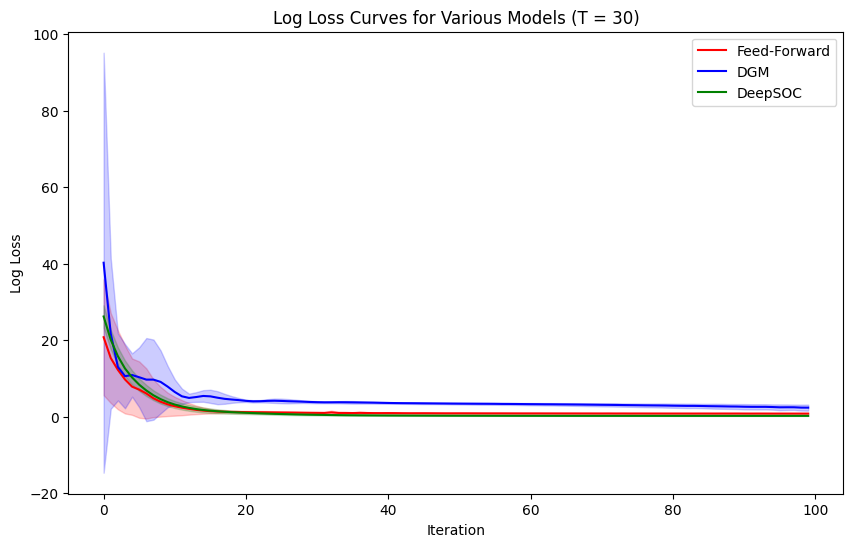

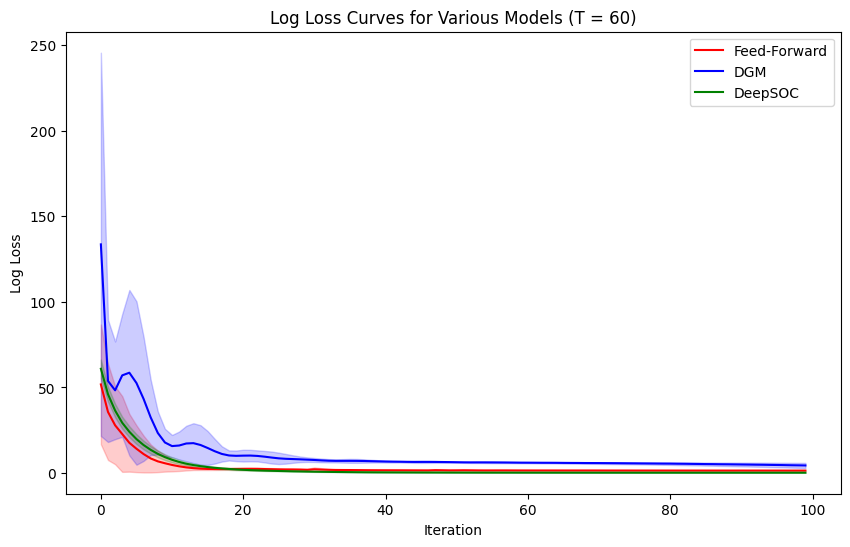

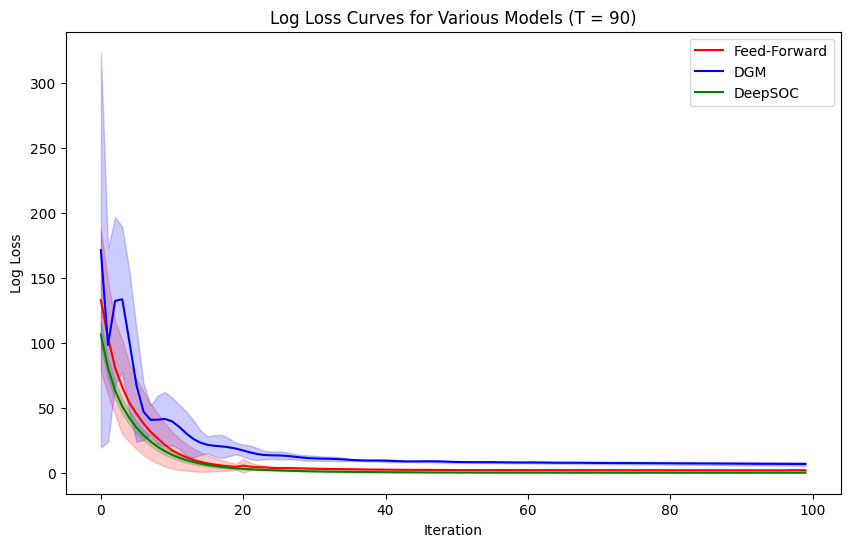

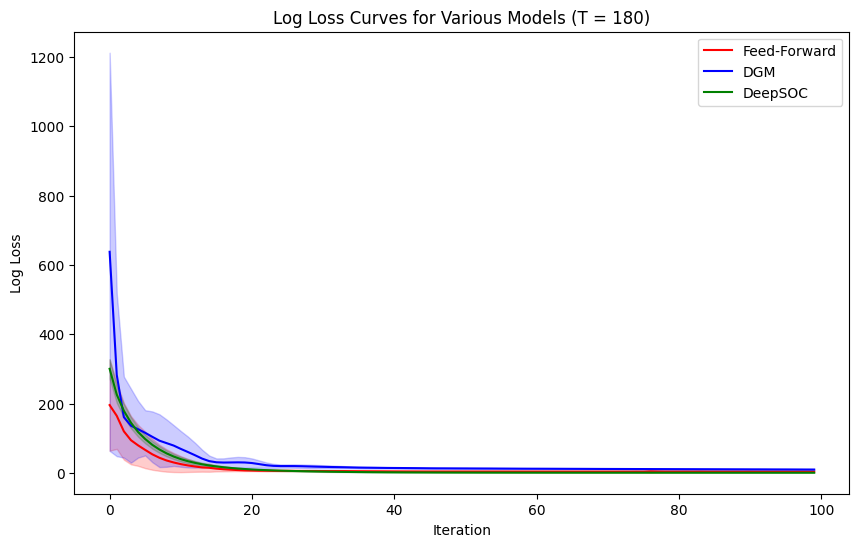

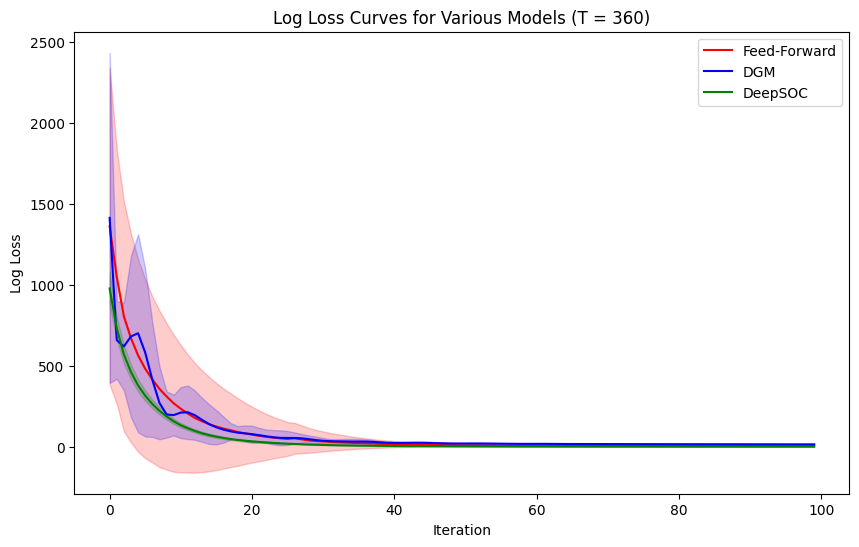

In [233]:
# Save performance metrics DataFrame to CSV
performance_metrics_df.to_csv('performance_metrics.csv', index=False)

# Load performance metrics DataFrame
performance_metrics_df = pd.read_csv('performance_metrics.csv')

# Plot Log Loss Curves
def plot_log_loss_curve(epochs, ff_data, dgm_data, dbsde_data, T):
    ff_mean = np.array(torch.mean(ff_data, 1).cpu())
    ff_std = np.array(torch.std(ff_data, 1).cpu())
    dgm_mean = np.array(torch.mean(dgm_data, 1).cpu())
    dgm_std = np.array(torch.std(dgm_data, 1).cpu())
    dbsde_mean = np.array(torch.mean(dbsde_data, 1).cpu())
    dbsde_std = np.array(torch.std(dbsde_data, 1).cpu())

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, ff_mean, label='Feed-Forward', color='red')
    plt.plot(epochs, dgm_mean, label='DGM', color='blue')
    plt.plot(epochs, dbsde_mean, label='DeepSOC', color='green')
    plt.fill_between(epochs, ff_mean - ff_std, ff_mean + ff_std, color='red', alpha=0.2)
    plt.fill_between(epochs, dgm_mean - dgm_std, dgm_mean + dgm_std, color='blue', alpha=0.2)
    plt.fill_between(epochs, dbsde_mean - dbsde_std, dbsde_mean + dbsde_std, color='green', alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title(f'Log Loss Curves for Various Models (T = {T})')
    plt.legend()
    plt.savefig(f'T{T}mat.png', format='png', dpi=300)
    plt.show()

# Generate plots for each T
plot_log_loss_curve(epochs, resultff30_data, resultdgm30_data, resultdbsde30_data, 30)
plot_log_loss_curve(epochs, resultff60_data, resultdgm60_data, resultdbsde60_data, 60)
plot_log_loss_curve(epochs, resultff90_data, resultdgm90_data, resultdbsde90_data, 90)
plot_log_loss_curve(epochs, resultff180_data, resultdgm180_data, resultdbsde180_data, 180)
plot_log_loss_curve(epochs, resultff360_data, resultdgm360_data, resultdbsde360_data, 360)

## Load

In [237]:
import torch

# Define a function to load data from a file
def load_data(filename):
    return torch.log2(torch.load(filename))

# Load data for different intervals
resultff30_data = load_data('resultff30_data.pt')
resultdbsde30_data = load_data('resultdbsde30_data.pt')
resultdgm30_data = load_data('resultdgm30_data.pt')

resultff60_data = load_data('resultff60_data.pt')
resultdbsde60_data = load_data('resultdbsde60_data.pt')
resultdgm60_data = load_data('resultdgm60_data.pt')

resultff90_data = load_data('resultff90_data.pt')
resultdbsde90_data = load_data('resultdbsde90_data.pt')
resultdgm90_data = load_data('resultdgm90_data.pt')

resultff180_data = load_data('resultff180_data.pt')
resultdbsde180_data = load_data('resultdbsde180_data.pt')
resultdgm180_data = load_data('resultdgm180_data.pt')

resultff360_data = load_data('resultff360_data.pt')
resultdbsde360_data = load_data('resultdbsde360_data.pt')
resultdgm360_data = load_data('resultdgm360_data.pt')


## Figures

### T = 30

In [229]:
ff_mean = np.array(torch.mean(resultff30_data, 1).cpu())
ff_std  =  np.array(torch.std(resultff30_data, 1).cpu())
dbsde_mean = np.array(torch.mean(resultdbsde30_data, 1).cpu())
dbsde_std = np.array(torch.std(resultdbsde30_data, 1).cpu())
dgm_mean =np.array(torch.mean(resultdgm30_data, 1).cpu())
dgm_std = np.array(torch.std(resultdgm30_data, 1).cpu())
st_idx = 30

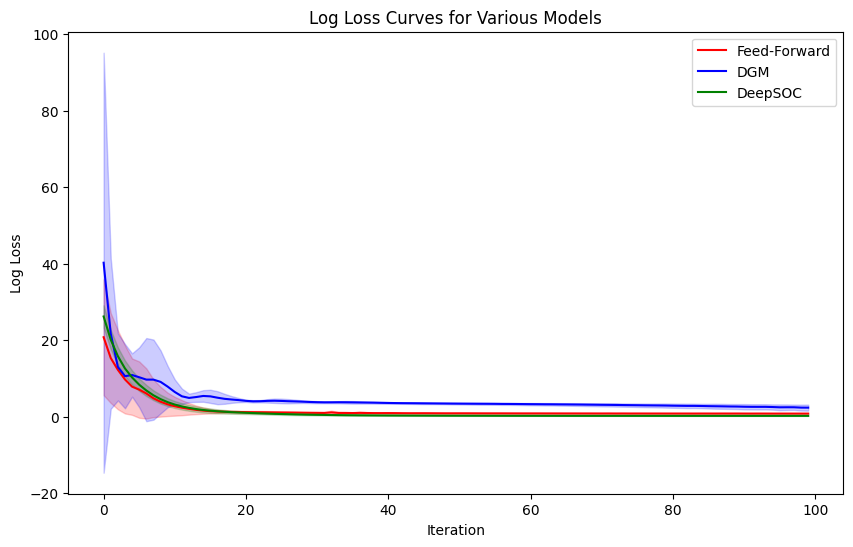

In [239]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data for the iterations

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model's mean loss curve
plt.plot(epochs, ff_mean, label='Feed-Forward', color='red')
plt.plot(epochs, dgm_mean, label='DGM', color='blue')
plt.plot(epochs, dbsde_mean, label='DeepSOC', color='green')

# Add shaded uncertainty bands
plt.fill_between(epochs, ff_mean - ff_std, ff_mean + ff_std, color='red', alpha=0.2)
plt.fill_between(epochs, dgm_mean - dgm_std, dgm_mean + dgm_std, color='blue', alpha=0.2)
plt.fill_between(epochs, dbsde_mean - dbsde_std, dbsde_mean + dbsde_std, color='green', alpha=0.2)

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss Curves for Various Models')
plt.legend()

# Show the plot
plt.savefig('T30mat.png', format='png', dpi=300)  # Save as PNG file with high resolution

plt.show()


### T = 60

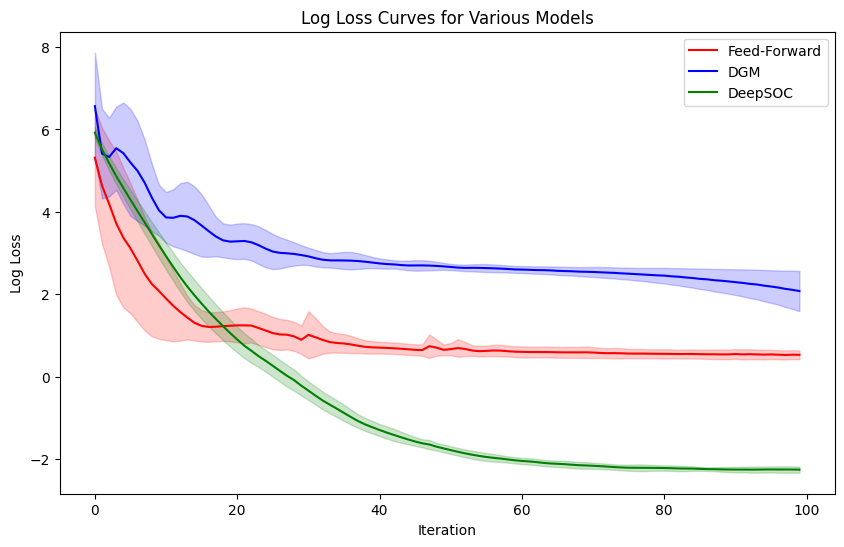

In [240]:
ff_mean = np.array(torch.mean(resultff60_data, 1).cpu())
ff_std  =  np.array(torch.std(resultff60_data, 1).cpu())
dbsde_mean = np.array(torch.mean(resultdbsde60_data, 1).cpu())
dbsde_std = np.array(torch.std(resultdbsde60_data, 1).cpu())
dgm_mean =np.array(torch.mean(resultdgm60_data, 1).cpu())
dgm_std = np.array(torch.std(resultdgm60_data, 1).cpu())

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model's mean loss curve
plt.plot(epochs, ff_mean, label='Feed-Forward', color='red')
plt.plot(epochs, dgm_mean, label='DGM', color='blue')
plt.plot(epochs, dbsde_mean, label='DeepSOC', color='green')

# Add shaded uncertainty bands
plt.fill_between(epochs, ff_mean - ff_std, ff_mean + ff_std, color='red', alpha=0.2)
plt.fill_between(epochs, dgm_mean - dgm_std, dgm_mean + dgm_std, color='blue', alpha=0.2)
plt.fill_between(epochs, dbsde_mean - dbsde_std, dbsde_mean + dbsde_std, color='green', alpha=0.2)

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss Curves for Various Models')
plt.legend()

# Show the plot
plt.savefig('T60mat.png', format='png', dpi=300)  # Save as PNG file with high resolution

plt.show()


### T = 90

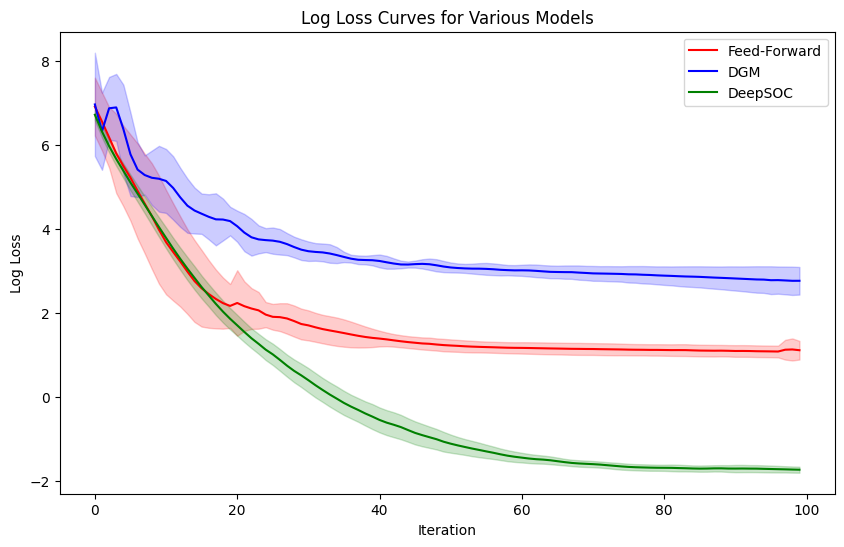

In [241]:
ff_mean = np.array(torch.mean(resultff90_data, 1).cpu())
ff_std  =  np.array(torch.std(resultff90_data, 1).cpu())
dbsde_mean = np.array(torch.mean(resultdbsde90_data, 1).cpu())
dbsde_std = np.array(torch.std(resultdbsde90_data, 1).cpu())
dgm_mean =np.array(torch.mean(resultdgm90_data, 1).cpu())
dgm_std = np.array(torch.std(resultdgm90_data, 1).cpu())

plt.figure(figsize=(10, 6))

# Plot each model's mean loss curve
plt.plot(epochs, ff_mean, label='Feed-Forward', color='red')
plt.plot(epochs, dgm_mean, label='DGM', color='blue')
plt.plot(epochs, dbsde_mean, label='DeepSOC', color='green')

# Add shaded uncertainty bands
plt.fill_between(epochs, ff_mean - ff_std, ff_mean + ff_std, color='red', alpha=0.2)
plt.fill_between(epochs, dgm_mean - dgm_std, dgm_mean + dgm_std, color='blue', alpha=0.2)
plt.fill_between(epochs, dbsde_mean - dbsde_std, dbsde_mean + dbsde_std, color='green', alpha=0.2)

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss Curves for Various Models')
plt.legend()

# Show the plot
plt.savefig('T90mat.png', format='png', dpi=300)  # Save as PNG file with high resolution

plt.show()


### T = 180

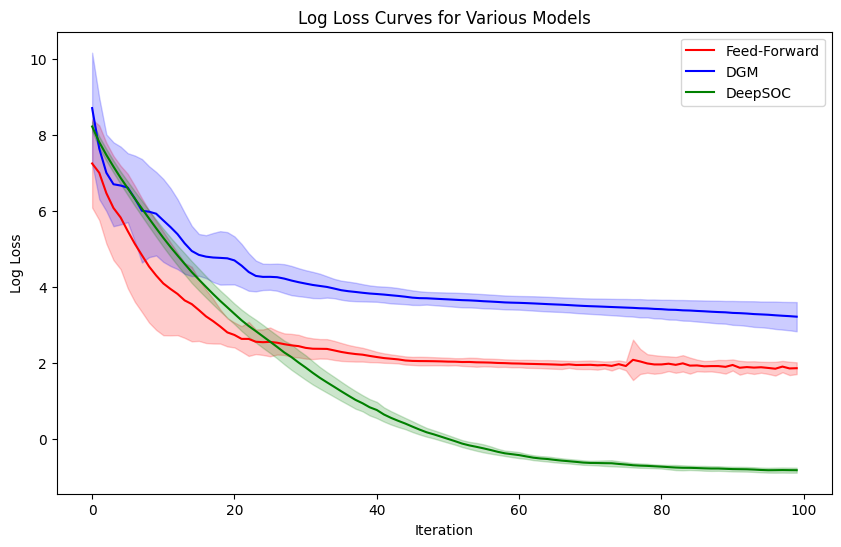

In [242]:
ff_mean = np.array(torch.mean(resultff180_data, 1).cpu())
ff_std  =  np.array(torch.std(resultff180_data, 1).cpu())
dbsde_mean = np.array(torch.mean(resultdbsde180_data, 1).cpu())
dbsde_std = np.array(torch.std(resultdbsde180_data, 1).cpu())
dgm_mean =np.array(torch.mean(resultdgm180_data, 1).cpu())
dgm_std = np.array(torch.std(resultdgm180_data, 1).cpu())

plt.figure(figsize=(10, 6))

# Plot each model's mean loss curve
plt.plot(epochs, ff_mean, label='Feed-Forward', color='red')
plt.plot(epochs, dgm_mean, label='DGM', color='blue')
plt.plot(epochs, dbsde_mean, label='DeepSOC', color='green')

# Add shaded uncertainty bands
plt.fill_between(epochs, ff_mean - ff_std, ff_mean + ff_std, color='red', alpha=0.2)
plt.fill_between(epochs, dgm_mean - dgm_std, dgm_mean + dgm_std, color='blue', alpha=0.2)
plt.fill_between(epochs, dbsde_mean - dbsde_std, dbsde_mean + dbsde_std, color='green', alpha=0.2)

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss Curves for Various Models')
plt.legend()

# Show the plot
plt.savefig('T180mat.png', format='png', dpi=300)  # Save as PNG file with high resolution


plt.show()


### T = 360

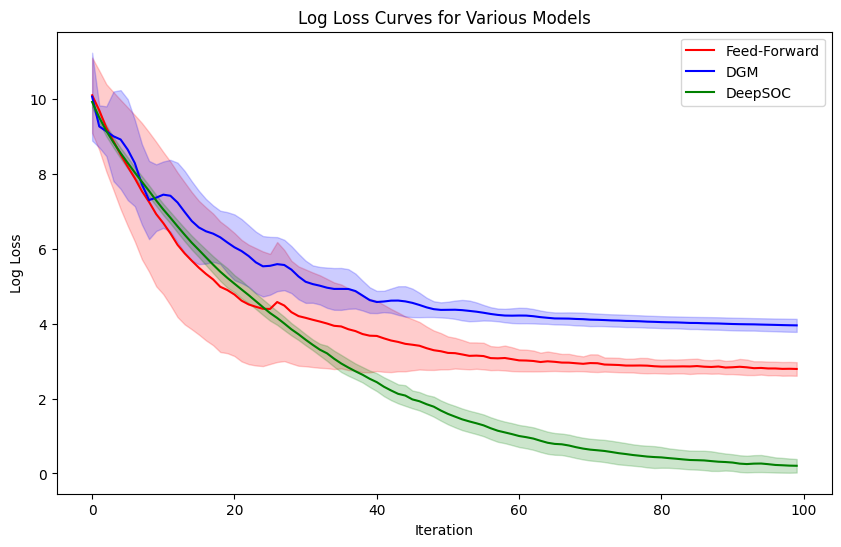

In [243]:
epochs = np.array([i for i in range(100)])

ff_mean = np.array(torch.mean(resultff360_data, 1).cpu())
ff_std  =  np.array(torch.std(resultff360_data, 1).cpu())
dbsde_mean = np.array(torch.mean(resultdbsde360_data, 1).cpu())
dbsde_std = np.array(torch.std(resultdbsde360_data, 1).cpu())
dgm_mean =np.array(torch.mean(resultdgm360_data, 1).cpu())
dgm_std = np.array(torch.std(resultdgm360_data, 1).cpu())
st_idx = 30
plt.figure(figsize=(10, 6))

# Plot each model's mean loss curve
plt.plot(epochs, ff_mean, label='Feed-Forward', color='red')
plt.plot(epochs, dgm_mean, label='DGM', color='blue')
plt.plot(epochs, dbsde_mean, label='DeepSOC', color='green')

# Add shaded uncertainty bands
plt.fill_between(epochs, ff_mean - ff_std, ff_mean + ff_std, color='red', alpha=0.2)
plt.fill_between(epochs, dgm_mean - dgm_std, dgm_mean + dgm_std, color='blue', alpha=0.2)
plt.fill_between(epochs, dbsde_mean - dbsde_std, dbsde_mean + dbsde_std, color='green', alpha=0.2)

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss Curves for Various Models')
plt.legend()

plt.savefig('T360mat.png', format='png', dpi=300)  # Save as PNG file with high resolution

# Show the plot

plt.show()


### All T

In [244]:
ffloss = np.array([np.array(torch.mean(resultff30_data, 1).cpu())[-1] , np.array(torch.mean(resultff60_data, 1).cpu())[-1] ,np.array(torch.mean(resultff90_data, 1).cpu())[-1],np.array(torch.mean(resultff180_data, 1).cpu())[-1],np.array(torch.mean(resultff360_data, 1).cpu())[-1] ])
dbsdeloss = np.array([np.array(torch.mean(resultdbsde30_data, 1).cpu())[-1] , np.array(torch.mean(resultdbsde60_data, 1).cpu())[-1] ,np.array(torch.mean(resultdbsde90_data, 1).cpu())[-1],np.array(torch.mean(resultdbsde180_data, 1).cpu())[-1],np.array(torch.mean(resultdbsde360_data, 1).cpu())[-1] ])
dgmloss = np.array([np.array(torch.mean(resultdgm30_data, 1).cpu())[-1] , np.array(torch.mean(resultdgm60_data, 1).cpu())[-1] ,np.array(torch.mean(resultdgm90_data, 1).cpu())[-1],np.array(torch.mean(resultdgm180_data, 1).cpu())[-1],np.array(torch.mean(resultdgm360_data, 1).cpu())[-1] ])

T = np.array([30,60,90,180,360])

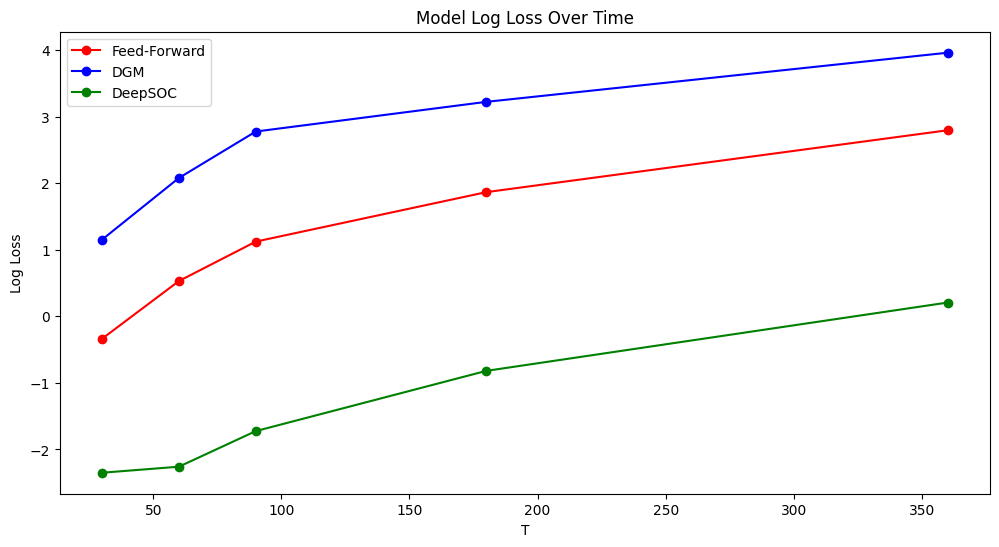

In [245]:
import numpy as np
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(12, 6))

# Plotting the data
plt.plot(T, ffloss, 'r', marker='o', label='Feed-Forward')  # Red line for Feed-Forward
plt.plot(T, dgmloss, 'b', marker='o', label='DGM')  # Blue line for DGM
plt.plot(T, dbsdeloss, 'g', marker='o', label='DeepSOC')  # Green line for DeepSOC


# Adding labels, title and grid
plt.xlabel('T')
plt.ylabel('Log Loss')
plt.title('Model Log Loss Over Time')
plt.legend()
plt.savefig('Tallmat.png', format='png', dpi=300)  # Save as PNG file with high resolution


# Show the plot
plt.show()


# Variance Valuation

In [246]:


def TRAIN_Utility_der(env, PHI_INITIAL,LAM,kappa,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,model_type ='Naive' , LR_Utility = 0.001,saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0):

    """
    n_samples: path size of the Brownian Motion
    time_step: discretization step
    LR_Utility: initial learning rate
    saving: list, to indicate at which epoch should have the models be saved to the path_temp
         saving=0 means no saving
    LR_Adjust: a dictoinary in which the value is the absolute DECAY,
          and the key is the epoch corresponding to the updated learning rate
    OPT_Utility: "ADAM" or "SGD"
    """
    model_list_Utility = []
    i = 0
    n_model = time_step



    while i <= n_model-1:
        f= False
        model = RL_Net(2*env.sp.dim + 1 ,env.sp.dim,HIDDEN_DIM_Utility , f).to(device)


        model.apply(weights_init_uniform_rule)
        model_list_Utility.append(model)
        i += 1
    V0 = torch.zeros(1).to(device).requires_grad_()
    if OPT_Utility=="SGD":
        optimizer_Utility = torch.optim.SGD((par for model in model_list_Utility
                        for par in model.parameters()),
                                lr=LR_Utility)
    if OPT_Utility=="ADAM":
        optimizer_first = torch.optim.Adam([V0],lr=LR_Utility, betas=(0.9, 0.99))

        optimizers = [torch.optim.Adam(model.parameters() ,lr=LR_Utility, betas=(0.9, 0.99)) for model in model_list_Utility ]
        optimizer_Utility = torch.optim.Adam((par for model in model_list_Utility
                        for par in model.parameters()),
                        lr=LR_Utility, betas=(0.9, 0.99))

    loss_arr_Utility = []
    PHI_0=torch.ones(n_samples,env.sp.dim)*PHI_INITIAL
    DUMMY_1 = torch.ones(n_samples).reshape((n_samples, 1))
    data = torch.zeros(EPOCH,time_step )
    data_mean = torch.zeros(EPOCH,time_step )
    for epoch in tqdm(range(EPOCH)):
        ### tuning the learning rate

        S = torch.tensor(env.sample(n_samples)[1]).to(torch.float32)

        ### Calculate option prices batch (SAMPLE_SIZE,TIME_STEP+1)

        optimizer_Utility.zero_grad()
        optimizer_first.zero_grad()
        for opt in optimizers:
          opt.zero_grad()
        PHI = torch.zeros((n_samples,env.sp.dim, time_step + 1)).to(device)

        PHI[:,:,0] = PHI_0.to(device)
        phi = torch.zeros((n_samples,env.sp.dim, time_step + 1)).to(device)

        phi[:,:,0] = PHI_0.to(device)


        PHI_dot = torch.zeros((n_samples,env.sp.dim, time_step )).to(device)


        for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(SAMPLE_SIZE,TIME_STEP)
            t_tensor=t/env.sp.num_time_interval *env.sp.total_time *torch.ones(n_samples).reshape(-1,1)
            x_Utility=torch.cat((t_tensor.to(device),S[:,:,t].to(device),PHI[:,:,t]),dim=1).to(device)
            if model_type == 'Naive':
              PHI_dot[:,:,t] = model_list_Utility[t%n_model](x_Utility)





            PHI[:,:,t+1] = PHI_dot[:,:,t] + PHI[:,:,t]


        C = env.sp.terminal(S[:,:,-1])
        loss_Utility, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate * env.sp.delta_t), V0,C.to(device), PHI,PHI_dot,LAM,kappa,time_step,env.sp.delta_t, n_samples)
        loss_arr_Utility.append(loss_Utility.data)
        for param in model_list_Utility[0].parameters():
          param.requires_grad = False
        for T in range(time_step):
          phi = torch.zeros((n_samples,env.sp.dim, time_step + 1)).to(device)
          phi[:,:,0] = PHI_0.to(device)
          phi_dot = torch.zeros((n_samples,env.sp.dim, time_step )).to(device)
          phidot =  []
          for t in range(time_step):
            t_tensor=t/env.sp.num_time_interval *env.sp.total_time *torch.ones(n_samples).reshape(-1,1)
            x_Utility=torch.cat((t_tensor.to(device),S[:,:,t].to(device),phi[:,:,t]),dim=1).to(device)
            V = model_list_Utility[t%n_model](x_Utility)
            if T == t:
              V = V.detach()
              V.requires_grad = True
              phidot = V
            phi_dot[:,:,t] = V
            phi[:,:,t+1] = phi_dot[:,:,t] + phi[:,:,t]

          l, _ = Mean_Utility(S.to(device),torch.tensor(env.sp.rate * env.sp.delta_t), V0,C.to(device), phi,phi_dot,LAM,kappa,time_step,env.sp.delta_t, n_samples)
          l = n_samples * l
          gradient = torch.autograd.grad(l,phidot)[0]
          #print(gradient)

          k = torch.squeeze(torch.std(gradient , dim = 0))
          data[epoch,T] = k.detach().cpu()
          data_mean[epoch,T] = torch.squeeze(torch.mean(gradient , dim = 0)).detach().cpu()



        loss_Utility.backward()

        # print(loss_Utility)
        optimizer_Utility.step()  #update NN weights


        #for i,opt in enumerate(optimizers):
          #opt.step()
          #print(torch.max(opt.state_dict()['state'][0]['exp_avg_sq']))
         # v_t_sqt[epoch,i] = torch.max(opt.state_dict()['state'][0]['exp_avg_sq'])


        optimizer_first.step()
        if np.isinf(loss_Utility.data.cpu().numpy()) or np.isnan(loss_Utility.data.cpu().numpy()):
            print("\nFAIL")
            break
        ### saving
        path_Q = './models/'
        if saving:
            if epoch%100==0:
                for i,model in enumerate(model_list_Utility):
                      torch.save(model.state_dict(),path_Q+'Utility_para{}.pkl'.format(i))
                torch.save(loss_arr_Utility,path_Q+"Utility_LOSS_arr.pt")
                torch.save(optimizer_Utility.state_dict(),path_Q+"Utility_optimizer.pt")
                print("\n saving models after {} Epochs".format(epoch+1))
    result={
        'loss':loss_arr_Utility,
        'model_list':model_list_Utility
      }
    return result , data, data_mean

In [247]:

PHI_INITIAL = 0.0
LAM = 0.1
TIME = 30
EPOCH =100
n_samples = 50000
time_step = 30
LR_Utility = 0.008
INPUT_DIM_Utility = 3 #The dimension of the input is 5:(t,W_t,C_t,Delta_t,phi_t)
OUTPUT_DIM = 1
HIDDEN_DIM_Utility = [10,15,10]

In [248]:
basic = {'dim' : 1 , 'total_time' : 30 , 'num_time_interval': 30 }
specific = {'init':100 , 'sigma':0.20/np.sqrt(252) , 'rate':0.0 , 'mu':0.05/252 , 'K' : 100}

env = TradingEnv(basic , specific)

In [249]:
result,data, data_mean = TRAIN_Utility_der(env,PHI_INITIAL,LAM,0,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,'Naive',LR_Utility, saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)

100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


In [250]:
data = data[0:100 , :].numpy()
data = np.log(data[:,:-1])
a = data


In [251]:
data = np.log(data)

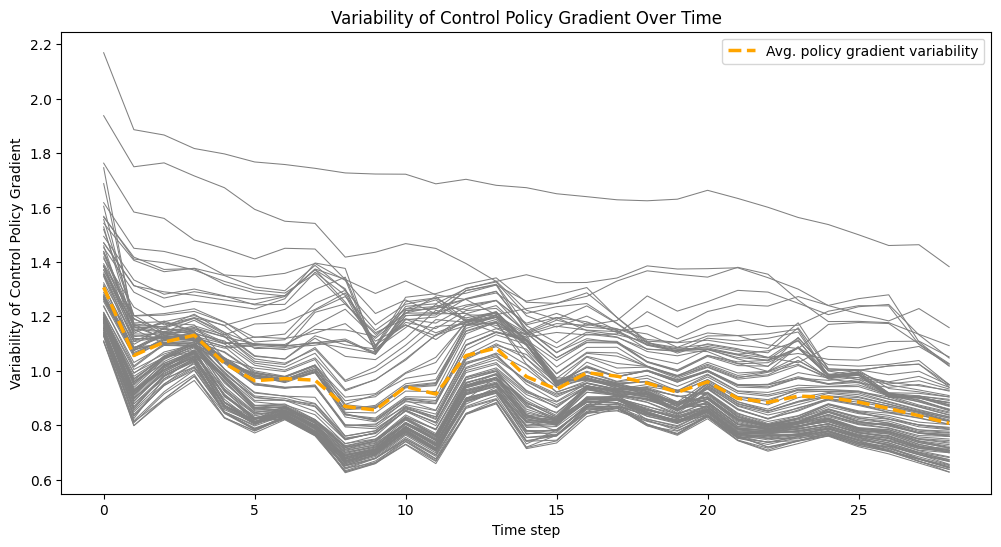

In [252]:
# Parameters
n_trials = 100

avg_data = np.mean(data, axis=0)

# Plotting
plt.figure(figsize=(12, 6))
for trial in data:
    plt.plot(trial, color='grey', linewidth=0.75)  # Plot each trial
plt.plot(avg_data, color='orange', label='Avg. policy gradient variability', linewidth=2.5, linestyle='--')  # Plot average line with dashed style

# Adding labels and title
plt.xlabel('Time step')
plt.ylabel('Variability of Control Policy Gradient')
plt.title('Variability of Control Policy Gradient Over Time')
plt.legend()

# Show plot
plt.show()


Variance Valuation DataFrame:
    Epoch                        Policy Gradient Variability
0       0  [-72.52532, -69.19905, -66.49939, -62.60159, -...
1       1  [-5.0685596, -3.0353181, -1.2123573, 1.470389,...
2       2  [16.837267, 19.129757, 21.079165, 23.757252, 2...
3       3  [9.313399, 11.581943, 13.605389, 16.478256, 18...
4       4  [-8.967844, -6.6821585, -4.7045684, -1.8258096...
..    ...                                                ...
95     95  [-2.1141782, 0.091101244, 0.045758806, 0.13595...
96     96  [-1.6448473, 0.5330657, 0.52051294, 0.6257609,...
97     97  [-1.6632235, 0.55537075, 0.5721631, 0.64997035...
98     98  [-2.4447255, -0.19517663, -0.20582207, -0.1022...
99     99  [-3.153798, -0.9680728, -0.94290566, -0.839554...

[100 rows x 2 columns]


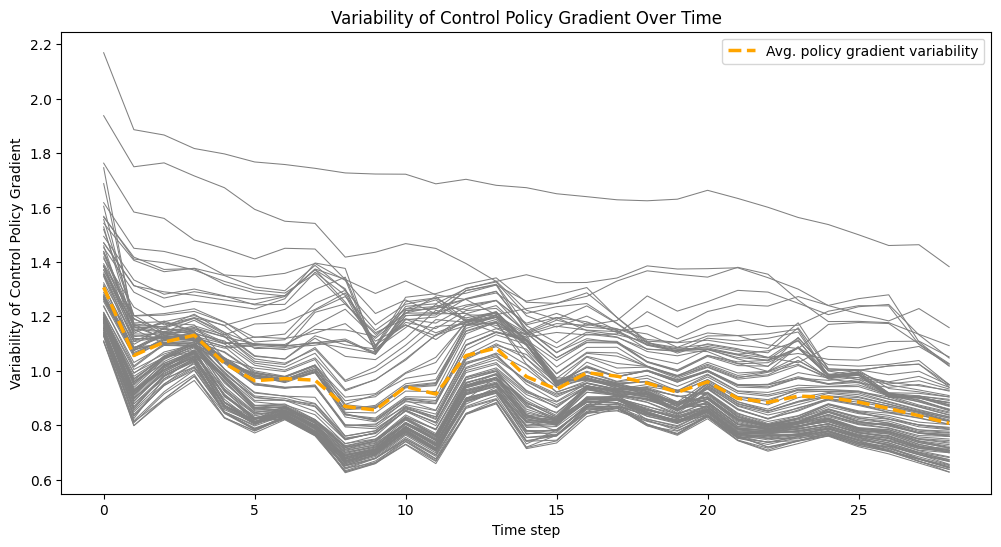

In [253]:
# Variance Valuation DataFrame
variance_valuation_data = {
    "Epoch": list(range(EPOCH)),
    "Policy Gradient Variability": list(data_mean.cpu().numpy())
}

variance_valuation_df = pd.DataFrame(variance_valuation_data)
variance_valuation_df.to_csv('variance_valuation.csv', index=False)

# Display Variance Valuation DataFrame
print("Variance Valuation DataFrame:")
print(variance_valuation_df)

# Plot Variability of Control Policy Gradient Over Time
plt.figure(figsize=(12, 6))
for trial in data:
    plt.plot(trial, color='grey', linewidth=0.75)
plt.plot(avg_data, color='orange', label='Avg. policy gradient variability', linewidth=2.5, linestyle='--')
plt.xlabel('Time step')
plt.ylabel('Variability of Control Policy Gradient')
plt.title('Variability of Control Policy Gradient Over Time')
plt.legend()
plt.savefig('variance_gradient.png', format='png', dpi=300)
plt.show()

# Tables

To generate tables with values calculated using your models, you need to perform the calculations within your training and evaluation loops, and then store the results in appropriate data structures. Here is how you can integrate this into your existing code:

### 1. Hyperparameters

```python
# Assuming hyperparameters are defined in your code as constants
hyperparameters_data = {
    "Model Type": ["Feed-Forward", "DGM", "Deep BSDE"],
    "Learning Rate": [0.008, 0.008, 0.008],
    "Batch Size": [5000, 5000, 5000],
    "Optimizer": ["Adam", "Adam", "Adam"],
    "Epochs": [100, 100, 100],
    "Hidden Layer Sizes": ["[10, 20, 20, 20, 20, 10]", "30", "[10, 20, 20, 20, 20, 10]"]
}

hyperparameters_df = pd.DataFrame(hyperparameters_data)
print("Hyperparameters:")
print(hyperparameters_df)
```

### 2. Computational Performance

To measure training time and memory usage, you can use the `time` library and `psutil` library.

```python
import time
import psutil

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert bytes to MB

# Example usage within your training function
start_time = time.time()
start_memory = get_memory_usage()

# Your training code here...

end_time = time.time()
end_memory = get_memory_usage()

training_time = end_time - start_time
memory_usage = end_memory - start_memory

# Collect results
computational_performance_data = {
    "Model Type": ["Feed-Forward", "Feed-Forward", "DGM", "DGM", "Deep BSDE", "Deep BSDE"],
    "Time Horizon (T)": [30, 60, 30, 60, 30, 60],
    "Training Time (s)": [ff_training_time_30, ff_training_time_60, dgm_training_time_30, dgm_training_time_60, dbsde_training_time_30, dbsde_training_time_60],
    "Memory Usage (MB)": [ff_memory_usage_30, ff_memory_usage_60, dgm_memory_usage_30, dgm_memory_usage_60, dbsde_memory_usage_30, dbsde_memory_usage_60]
}

computational_performance_df = pd.DataFrame(computational_performance_data)
print("Computational Performance:")
print(computational_performance_df)
```

### 3. Performance Metrics Over Different Transaction Costs

You need to modify your existing training loop to iterate over different transaction costs and record the performance metrics.

```python
transaction_costs = [0.00, 0.01, 0.05]
performance_metrics_data = []

for tc in transaction_costs:
    # Update your environment or model with the new transaction cost
    transaction = tc

    # Perform training and get the log loss
    resultff = TRAIN_Utility(env, price, PHI_INITIAL, LAM, tc, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'FF', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
    resultdgm = TRAIN_Utility(env, price, PHI_INITIAL, LAM, tc, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'DGM', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
    resultdbsde = TRAIN_Utility(env, price, PHI_INITIAL, LAM, tc, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'Deep BSDE', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)

    ff_mean_log_loss = np.mean(resultff['loss'])
    dgm_mean_log_loss = np.mean(resultdgm['loss'])
    dbsde_mean_log_loss = np.mean(resultdbsde['loss'])

    performance_metrics_data.append([tc, ff_mean_log_loss, dgm_mean_log_loss, dbsde_mean_log_loss])

performance_metrics_df = pd.DataFrame(performance_metrics_data, columns=["Transaction Cost", "Feed-Forward Mean Log Loss", "DGM Mean Log Loss", "Deep BSDE Mean Log Loss"])
print("Performance Metrics Over Different Transaction Costs:")
print(performance_metrics_df)
```

### 4. Sensitivity Analysis

You can perform sensitivity analysis by varying the parameters and recording the performance metrics.

```python
sensitivity_parameters = {
    "Initial Stock Price (S0)": [90, 100, 110],
    "Volatility (σ)": [0.15, 0.20, 0.25],
    "Interest Rate (r)": [0.03, 0.05, 0.07]
}

sensitivity_data = []

for param_name, values in sensitivity_parameters.items():
    for value in values:
        # Update your environment or model with the new parameter value
        if param_name == "Initial Stock Price (S0)":
            env.sp.x_init = value
        elif param_name == "Volatility (σ)":
            env.sp.sigma = value
        elif param_name == "Interest Rate (r)":
            env.sp.rate = value

        # Perform training and get the log loss
        resultff = TRAIN_Utility(env, price, PHI_INITIAL, LAM, transaction, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'FF', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
        resultdgm = TRAIN_Utility(env, price, PHI_INITIAL, LAM, transaction, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'DGM', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
        resultdbsde = TRAIN_Utility(env, price, PHI_INITIAL, LAM, transaction, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'Deep BSDE', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)

        ff_mean_log_loss = np.mean(resultff['loss'])
        dgm_mean_log_loss = np.mean(resultdgm['loss'])
        dbsde_mean_log_loss = np.mean(resultdbsde['loss'])

        sensitivity_data.append([param_name, value, ff_mean_log_loss, dgm_mean_log_loss, dbsde_mean_log_loss])

sensitivity_df = pd.DataFrame(sensitivity_data, columns=["Parameter", "Value", "Feed-Forward Sensitivity", "DGM Sensitivity", "Deep BSDE Sensitivity"])
print("Sensitivity Analysis:")
print(sensitivity_df)
```

### Inserting the Code in Your Script

Insert these additional calculations and table generation after your training loops and before saving the results. Here’s an example of where to insert this in your code:

```python
# Assuming your training loops are here...

# Insert the additional table generation code here

# Hyperparameters
hyperparameters_data = {
    "Model Type": ["Feed-Forward", "DGM", "Deep BSDE"],
    "Learning Rate": [0.008, 0.008, 0.008],
    "Batch Size": [5000, 5000, 5000],
    "Optimizer": ["Adam", "Adam", "Adam"],
    "Epochs": [100, 100, 100],
    "Hidden Layer Sizes": ["[10, 20, 20, 20, 20, 10]", "30", "[10, 20, 20, 20, 20, 10]"]
}

hyperparameters_df = pd.DataFrame(hyperparameters_data)
print("Hyperparameters:")
print(hyperparameters_df)

# Computational Performance
computational_performance_data = {
    "Model Type": ["Feed-Forward", "Feed-Forward", "DGM", "DGM", "Deep BSDE", "Deep BSDE"],
    "Time Horizon (T)": [30, 60, 30, 60, 30, 60],
    "Training Time (s)": [ff_training_time_30, ff_training_time_60, dgm_training_time_30, dgm_training_time_60, dbsde_training_time_30, dbsde_training_time_60],
    "Memory Usage (MB)": [ff_memory_usage_30, ff_memory_usage_60, dgm_memory_usage_30, dgm_memory_usage_60, dbsde_memory_usage_30, dbsde_memory_usage_60]
}

computational_performance_df = pd.DataFrame(computational_performance_data)
print("Computational Performance:")
print(computational_performance_df)

# Performance Metrics Over Different Transaction Costs
transaction_costs = [0.00, 0.01, 0.05]
performance_metrics_data = []

for tc in transaction_costs:
    transaction = tc

    resultff = TRAIN_Utility(env, price,

 PHI_INITIAL, LAM, tc, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'FF', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
    resultdgm = TRAIN_Utility(env, price, PHI_INITIAL, LAM, tc, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'DGM', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
    resultdbsde = TRAIN_Utility(env, price, PHI_INITIAL, LAM, tc, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'Deep BSDE', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)

    ff_mean_log_loss = np.mean(resultff['loss'])
    dgm_mean_log_loss = np.mean(resultdgm['loss'])
    dbsde_mean_log_loss = np.mean(resultdbsde['loss'])

    performance_metrics_data.append([tc, ff_mean_log_loss, dgm_mean_log_loss, dbsde_mean_log_loss])

performance_metrics_df = pd.DataFrame(performance_metrics_data, columns=["Transaction Cost", "Feed-Forward Mean Log Loss", "DGM Mean Log Loss", "Deep BSDE Mean Log Loss"])
print("Performance Metrics Over Different Transaction Costs:")
print(performance_metrics_df)

# Sensitivity Analysis
sensitivity_parameters = {
    "Initial Stock Price (S0)": [90, 100, 110],
    "Volatility (σ)": [0.15, 0.20, 0.25],
    "Interest Rate (r)": [0.03, 0.05, 0.07]
}

sensitivity_data = []

for param_name, values in sensitivity_parameters.items():
    for value in values:
        if param_name == "Initial Stock Price (S0)":
            env.sp.x_init = value
        elif param_name == "Volatility (σ)":
            env.sp.sigma = value
        elif param_name == "Interest Rate (r)":
            env.sp.rate = value

        resultff = TRAIN_Utility(env, price, PHI_INITIAL, LAM, transaction, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'FF', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
        resultdgm = TRAIN_Utility(env, price, PHI_INITIAL, LAM, transaction, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'DGM', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)
        resultdbsde = TRAIN_Utility(env, price, PHI_INITIAL, LAM, transaction, TIME, EPOCH, n_samples, time_step, HIDDEN_DIM_Utility, 'Deep BSDE', LR_Utility, saving=0, LR_Adjust=dict(), OPT_Utility="ADAM", SEED_Utility1=0, SEED_Utility2=0)

        ff_mean_log_loss = np.mean(resultff['loss'])
        dgm_mean_log_loss = np.mean(resultdgm['loss'])
        dbsde_mean_log_loss = np.mean(resultdbsde['loss'])

        sensitivity_data.append([param_name, value, ff_mean_log_loss, dgm_mean_log_loss, dbsde_mean_log_loss])

sensitivity_df = pd.DataFrame(sensitivity_data, columns=["Parameter", "Value", "Feed-Forward Sensitivity", "DGM Sensitivity", "Deep BSDE Sensitivity"])
print("Sensitivity Analysis:")
print(sensitivity_df)

# Your existing code to save results and generate figures follows here
# Save results and generate figures
```

Replace placeholders like `ff_training_time_30`, `ff_memory_usage_30`, `Value1`, etc., with the actual values obtained from your experiments. This will create and print the tables, which you can then use in your paper.